***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Non-linear Burgers equation
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINN Architecture

In [2]:
node = 8
class PINNs(nn.Module):
    """PINNs"""
    def setup(self):
        self.layers = [nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]
    
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, t = inputs[:,0:1], inputs[:,1:2]
        
        def get_u(x, t):
            u = jnp.hstack([x, t])
            for i, lyr in enumerate(self.layers):
                u = lyr(u)
            return u
        
        u = get_u(x, t)
        
        # obtain u_t
        def get_u_t(get_u, x, t):
            u_t = jacfwd(get_u, 1)(x, t)
            return u_t
    
        u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
        u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
        
        #obtain u_x
        def get_u_x(get_u, x, t):
            u_x = jacfwd(get_u)(x, t)
            return u_x
        
        u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
        u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
        
        #obtain u_xx    
        def get_u_xx(get_u, x, t):
            u_xx = hessian(get_u)(x,t)
            return u_xx
        
        u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
        u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)
        
        action = jnp.hstack([u, u_x, u_xx, u_t])   
        return action

# initialize model
model = PINNs()    

In [3]:
# choose seed
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,2]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

176

Problem

In [5]:
def f_ic(x):
    return jnp.exp(-(k*x)**2)

Hyper parameters and data 

In [6]:
import numpy as np
import pandas as pd

In [7]:
vis = 0.001

# initial condition
k = 2

# spatial domain
x_l, x_u = -2.0, 2.0

# time domain: 0 - t_T
t_T = 2.0

sim = pd.read_csv('nonlinear.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
x = x_train[:,0:1].reshape(-1,1)
t = x_train[:,1:2].reshape(-1,1)

_train1 = np.argwhere(t != 0.0)[:, 0]
x_train1 = x[_train1].reshape(-1,1)
t_train1 = t[_train1].reshape(-1,1)
y_train1 = y_train[_train1].reshape(-1,1)

_train2 = np.argwhere(t == 0.0)[:, 0]
x_train2 = x[_train2].reshape(-1,1)
t_train2 = t[_train2].reshape(-1,1)
y_train2 = y_train[_train2].reshape(-1,1)

data_all = jnp.hstack([x,t])
label_all = y_train
data_pde = jnp.hstack([x_train1, t_train1])
label_pde = y_train1
data_bc = jnp.hstack([x_train2, t_train2])
label_bc = y_train2
label_pde.shape[0]

25800

Loss Function

In [8]:
# loss function parameter
lmbda = 1 #500

In [9]:
def loss(params, inputs):
    x = inputs[:,0:1].reshape(-1,1)
    t = inputs[:,1:2].reshape(-1,1)
    prediction = model.apply(format_params_fn(params), jnp.hstack([x, t]))
    u, u_x, u_xx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4]
    # ground truth
    t_u = f_ic(x) 
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
    # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
    ic_mse = jnp.sum(jnp.square((t_u - u)*_ic)) / jnp.sum(_ic)
    # PDE (physics laws) 
    pde = u_t + u*u_x - vis*u_xx
    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde = pde * _pde
    pde_mse = jnp.sum(jnp.square(pde)) / jnp.sum(_pde)
    pde_mse = pde_mse 
    loss = pde_mse + ic_mse    
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [10]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [11]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer (SGD)

In [12]:
alpha = 0.1
optimizer = optax.sgd(learning_rate=alpha)
opt_state = optimizer.init(params)

Minibatching

In [13]:
BS_pde = 100
BS_bc = 5

def minibatch(train_iters):
    _batch_pde = jax.random.choice(random.PRNGKey(train_iters), label_pde.shape[0], (BS_pde,))
    _batch_bc = jax.random.choice(random.PRNGKey(train_iters), label_bc.shape[0], (BS_bc,))    
    batch_data = jnp.vstack([data_pde[_batch_pde], data_bc[_batch_bc]])
    return batch_data

minibatch = jit(minibatch)

Training 

In [14]:
# store weights
papas = {}
papas[0] = params

max_iters = 1500000
minloss = jnp.inf
fullbatchloss = jnp.inf
fullbatchloss_ls = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    # compute full batch loss (every 1 iterations)
    if (train_iters % 1 == 0):
        loss_value, _ = loss_grad(params, data_all)    
        fullbatchloss = min(fullbatchloss, loss_value)
    # mini-batching
    batch_data = minibatch(train_iters)
    # stochastic update
    start = time.time()
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    # store hsitory.
    runtime += (end-start)   
    fullbatchloss_ls.append([train_iters, runtime, loss_value, fullbatchloss])
    # append weights
    save_iters = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    if (train_iters in save_iters):
        papas[train_iters] = params
        #print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
    # store weights when the full-batch loss is smallest
    if fullbatchloss < minloss:
        print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
        minloss = fullbatchloss
        papas[-1] = params
    train_iters += 1
              
# final train_iters
print (train_iters, minloss)

iter. = 0  time = 0.99s  loss = 6.10e-01  min. (full batch) loss = 7.80e-01
iter. = 1  time = 0.99s  loss = 7.12e-01  min. (full batch) loss = 4.71e-01
iter. = 2  time = 0.99s  loss = 1.78e-01  min. (full batch) loss = 2.60e-01
iter. = 3  time = 0.99s  loss = 2.99e-01  min. (full batch) loss = 1.61e-01
iter. = 4  time = 0.99s  loss = 1.89e-01  min. (full batch) loss = 1.34e-01
iter. = 6  time = 0.99s  loss = 1.39e-01  min. (full batch) loss = 1.33e-01
iter. = 7  time = 0.99s  loss = 8.08e-02  min. (full batch) loss = 1.12e-01
iter. = 9  time = 0.99s  loss = 1.40e-01  min. (full batch) loss = 1.10e-01
iter. = 13  time = 0.99s  loss = 5.80e-02  min. (full batch) loss = 1.05e-01
iter. = 17  time = 0.99s  loss = 1.34e-01  min. (full batch) loss = 1.04e-01
iter. = 22  time = 0.99s  loss = 2.38e-01  min. (full batch) loss = 1.01e-01
iter. = 30  time = 1.00s  loss = 1.47e-01  min. (full batch) loss = 9.92e-02
iter. = 36  time = 1.00s  loss = 5.05e-02  min. (full batch) loss = 9.82e-02
iter. =

iter. = 422  time = 1.11s  loss = 2.37e-02  min. (full batch) loss = 2.09e-02
iter. = 423  time = 1.11s  loss = 1.22e-02  min. (full batch) loss = 2.04e-02
iter. = 431  time = 1.11s  loss = 1.28e-02  min. (full batch) loss = 2.02e-02
iter. = 440  time = 1.12s  loss = 1.35e-02  min. (full batch) loss = 1.99e-02
iter. = 442  time = 1.12s  loss = 1.18e-02  min. (full batch) loss = 1.98e-02
iter. = 450  time = 1.12s  loss = 2.90e-02  min. (full batch) loss = 1.96e-02
iter. = 459  time = 1.12s  loss = 8.23e-03  min. (full batch) loss = 1.95e-02
iter. = 461  time = 1.12s  loss = 2.47e-02  min. (full batch) loss = 1.93e-02
iter. = 470  time = 1.13s  loss = 2.40e-02  min. (full batch) loss = 1.90e-02
iter. = 485  time = 1.13s  loss = 3.13e-02  min. (full batch) loss = 1.86e-02
iter. = 500  time = 1.14s  loss = 3.93e-02  min. (full batch) loss = 1.85e-02
iter. = 507  time = 1.14s  loss = 1.57e-02  min. (full batch) loss = 1.82e-02
iter. = 509  time = 1.14s  loss = 1.65e-02  min. (full batch) lo

iter. = 1406  time = 1.45s  loss = 9.97e-03  min. (full batch) loss = 1.02e-02
iter. = 1424  time = 1.46s  loss = 1.08e-02  min. (full batch) loss = 1.01e-02
iter. = 1463  time = 1.47s  loss = 1.45e-02  min. (full batch) loss = 1.00e-02
iter. = 1485  time = 1.48s  loss = 1.20e-02  min. (full batch) loss = 1.00e-02
iter. = 1519  time = 1.49s  loss = 1.16e-02  min. (full batch) loss = 1.00e-02
iter. = 1520  time = 1.49s  loss = 3.90e-03  min. (full batch) loss = 9.99e-03
iter. = 1521  time = 1.49s  loss = 8.64e-03  min. (full batch) loss = 9.98e-03
iter. = 1531  time = 1.49s  loss = 8.16e-03  min. (full batch) loss = 9.88e-03
iter. = 1548  time = 1.50s  loss = 6.79e-03  min. (full batch) loss = 9.85e-03
iter. = 1565  time = 1.50s  loss = 1.02e-02  min. (full batch) loss = 9.84e-03
iter. = 1626  time = 1.53s  loss = 9.60e-03  min. (full batch) loss = 9.82e-03
iter. = 1637  time = 1.53s  loss = 7.39e-03  min. (full batch) loss = 9.72e-03
iter. = 1670  time = 1.54s  loss = 5.57e-03  min. (f

iter. = 4614  time = 2.50s  loss = 5.02e-03  min. (full batch) loss = 7.84e-03
iter. = 4748  time = 2.54s  loss = 6.23e-03  min. (full batch) loss = 7.82e-03
iter. = 4790  time = 2.55s  loss = 7.44e-03  min. (full batch) loss = 7.81e-03
iter. = 4835  time = 2.57s  loss = 5.44e-03  min. (full batch) loss = 7.79e-03
iter. = 4850  time = 2.57s  loss = 8.78e-03  min. (full batch) loss = 7.78e-03
iter. = 4939  time = 2.60s  loss = 8.81e-03  min. (full batch) loss = 7.77e-03
iter. = 4947  time = 2.60s  loss = 7.58e-03  min. (full batch) loss = 7.75e-03
iter. = 5000  time = 2.62s  loss = 6.62e-03  min. (full batch) loss = 7.74e-03
iter. = 5094  time = 2.65s  loss = 1.15e-02  min. (full batch) loss = 7.73e-03
iter. = 5126  time = 2.66s  loss = 5.95e-03  min. (full batch) loss = 7.72e-03
iter. = 5214  time = 2.69s  loss = 5.46e-03  min. (full batch) loss = 7.70e-03
iter. = 5222  time = 2.70s  loss = 6.00e-03  min. (full batch) loss = 7.69e-03
iter. = 5224  time = 2.70s  loss = 7.67e-03  min. (f

iter. = 13069  time = 5.28s  loss = 5.37e-03  min. (full batch) loss = 6.91e-03
iter. = 13166  time = 5.31s  loss = 5.69e-03  min. (full batch) loss = 6.90e-03
iter. = 13441  time = 5.40s  loss = 9.58e-03  min. (full batch) loss = 6.90e-03
iter. = 13504  time = 5.42s  loss = 5.01e-03  min. (full batch) loss = 6.89e-03
iter. = 13577  time = 5.45s  loss = 1.12e-02  min. (full batch) loss = 6.89e-03
iter. = 13708  time = 5.49s  loss = 7.28e-03  min. (full batch) loss = 6.88e-03
iter. = 13875  time = 5.55s  loss = 5.12e-03  min. (full batch) loss = 6.88e-03
iter. = 13916  time = 5.56s  loss = 4.12e-03  min. (full batch) loss = 6.88e-03
iter. = 13930  time = 5.57s  loss = 6.72e-03  min. (full batch) loss = 6.87e-03
iter. = 14014  time = 5.60s  loss = 9.42e-03  min. (full batch) loss = 6.87e-03
iter. = 14201  time = 5.66s  loss = 4.85e-03  min. (full batch) loss = 6.86e-03
iter. = 14247  time = 5.67s  loss = 5.65e-03  min. (full batch) loss = 6.86e-03
iter. = 14472  time = 5.74s  loss = 9.82

iter. = 30028  time = 11.03s  loss = 7.62e-03  min. (full batch) loss = 6.43e-03
iter. = 30651  time = 11.25s  loss = 6.54e-03  min. (full batch) loss = 6.42e-03
iter. = 30816  time = 11.30s  loss = 8.40e-03  min. (full batch) loss = 6.41e-03
iter. = 31153  time = 11.41s  loss = 1.07e-02  min. (full batch) loss = 6.40e-03
iter. = 31333  time = 11.47s  loss = 9.27e-03  min. (full batch) loss = 6.40e-03
iter. = 31419  time = 11.50s  loss = 1.12e-02  min. (full batch) loss = 6.40e-03
iter. = 31466  time = 11.52s  loss = 7.07e-03  min. (full batch) loss = 6.39e-03
iter. = 31691  time = 11.60s  loss = 4.14e-03  min. (full batch) loss = 6.39e-03
iter. = 31753  time = 11.62s  loss = 5.20e-03  min. (full batch) loss = 6.39e-03
iter. = 31758  time = 11.62s  loss = 5.02e-03  min. (full batch) loss = 6.39e-03
iter. = 32026  time = 11.70s  loss = 3.15e-03  min. (full batch) loss = 6.38e-03
iter. = 32027  time = 11.70s  loss = 3.80e-03  min. (full batch) loss = 6.38e-03
iter. = 32318  time = 11.79s

iter. = 49494  time = 17.55s  loss = 9.50e-03  min. (full batch) loss = 6.02e-03
iter. = 50041  time = 17.75s  loss = 4.91e-03  min. (full batch) loss = 6.01e-03
iter. = 50396  time = 17.86s  loss = 5.15e-03  min. (full batch) loss = 6.01e-03
iter. = 50400  time = 17.86s  loss = 4.12e-03  min. (full batch) loss = 6.01e-03
iter. = 50558  time = 17.92s  loss = 4.94e-03  min. (full batch) loss = 6.00e-03
iter. = 50827  time = 18.01s  loss = 6.19e-03  min. (full batch) loss = 6.00e-03
iter. = 50830  time = 18.01s  loss = 8.61e-03  min. (full batch) loss = 5.99e-03
iter. = 51138  time = 18.12s  loss = 5.98e-03  min. (full batch) loss = 5.99e-03
iter. = 51241  time = 18.15s  loss = 3.54e-03  min. (full batch) loss = 5.98e-03
iter. = 51829  time = 18.35s  loss = 5.21e-03  min. (full batch) loss = 5.98e-03
iter. = 52029  time = 18.42s  loss = 4.96e-03  min. (full batch) loss = 5.98e-03
iter. = 52085  time = 18.44s  loss = 9.48e-03  min. (full batch) loss = 5.97e-03
iter. = 53057  time = 18.76s

iter. = 72819  time = 25.37s  loss = 6.95e-03  min. (full batch) loss = 5.66e-03
iter. = 73486  time = 25.59s  loss = 6.85e-03  min. (full batch) loss = 5.65e-03
iter. = 73495  time = 25.59s  loss = 7.37e-03  min. (full batch) loss = 5.65e-03
iter. = 74010  time = 25.76s  loss = 6.23e-03  min. (full batch) loss = 5.65e-03
iter. = 74224  time = 25.84s  loss = 3.38e-03  min. (full batch) loss = 5.64e-03
iter. = 74369  time = 25.89s  loss = 5.50e-03  min. (full batch) loss = 5.64e-03
iter. = 74394  time = 25.90s  loss = 3.06e-03  min. (full batch) loss = 5.63e-03
iter. = 75090  time = 26.15s  loss = 4.44e-03  min. (full batch) loss = 5.62e-03
iter. = 75354  time = 26.24s  loss = 7.76e-03  min. (full batch) loss = 5.62e-03
iter. = 75510  time = 26.28s  loss = 9.58e-03  min. (full batch) loss = 5.61e-03
iter. = 76362  time = 26.58s  loss = 5.31e-03  min. (full batch) loss = 5.61e-03
iter. = 76378  time = 26.58s  loss = 4.53e-03  min. (full batch) loss = 5.61e-03
iter. = 76690  time = 26.69s

iter. = 105752  time = 36.56s  loss = 5.56e-03  min. (full batch) loss = 5.26e-03
iter. = 105888  time = 36.61s  loss = 5.58e-03  min. (full batch) loss = 5.26e-03
iter. = 105895  time = 36.61s  loss = 5.14e-03  min. (full batch) loss = 5.25e-03
iter. = 106440  time = 36.79s  loss = 6.64e-03  min. (full batch) loss = 5.25e-03
iter. = 106606  time = 36.84s  loss = 5.79e-03  min. (full batch) loss = 5.24e-03
iter. = 106861  time = 36.92s  loss = 6.54e-03  min. (full batch) loss = 5.23e-03
iter. = 107653  time = 37.17s  loss = 5.26e-03  min. (full batch) loss = 5.23e-03
iter. = 108577  time = 37.47s  loss = 1.06e-02  min. (full batch) loss = 5.22e-03
iter. = 109942  time = 37.92s  loss = 6.12e-03  min. (full batch) loss = 5.22e-03
iter. = 110078  time = 37.96s  loss = 7.38e-03  min. (full batch) loss = 5.21e-03
iter. = 110100  time = 37.97s  loss = 2.14e-03  min. (full batch) loss = 5.21e-03
iter. = 110675  time = 38.16s  loss = 3.63e-03  min. (full batch) loss = 5.21e-03
iter. = 110707  

In [15]:
# process results
import numpy as np
import pandas as pd

In [16]:
fullbatchloss_ls = np.array(fullbatchloss_ls)
# write convergence history to file
# df = pd.DataFrame(fullbatchloss_ls, columns=[['Training Iteration', 'Training Time', 'Minibatch Loss', 'Fullbatch Loss']])
# df.to_csv('nonlinear_sgd_minibatch_%d.csv'%(seed), index=False)
# df
fullbatchloss_ls[-1]

array([1.76225000e+05, 6.00000474e+01, 3.57879372e-03, 4.83737141e-03])

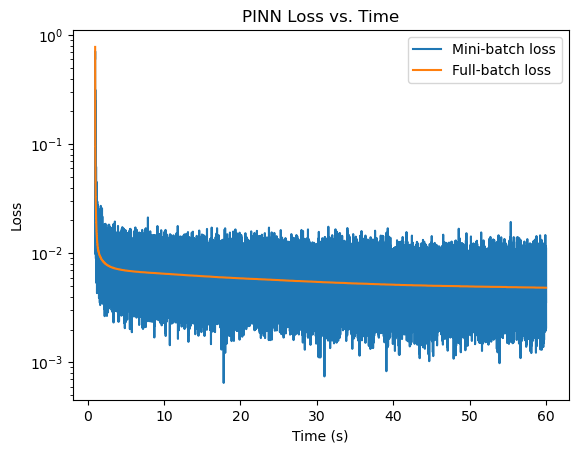

In [17]:
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 2], label='Mini-batch loss'); plt.yscale('log');
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 3], label='Full-batch loss');
plt.title('PINN Loss vs. Time'); plt.xlabel('Time (s)'); plt.ylabel('Loss'); plt.legend();

#### Visualize results

DeviceArray(0.00638547, dtype=float32)

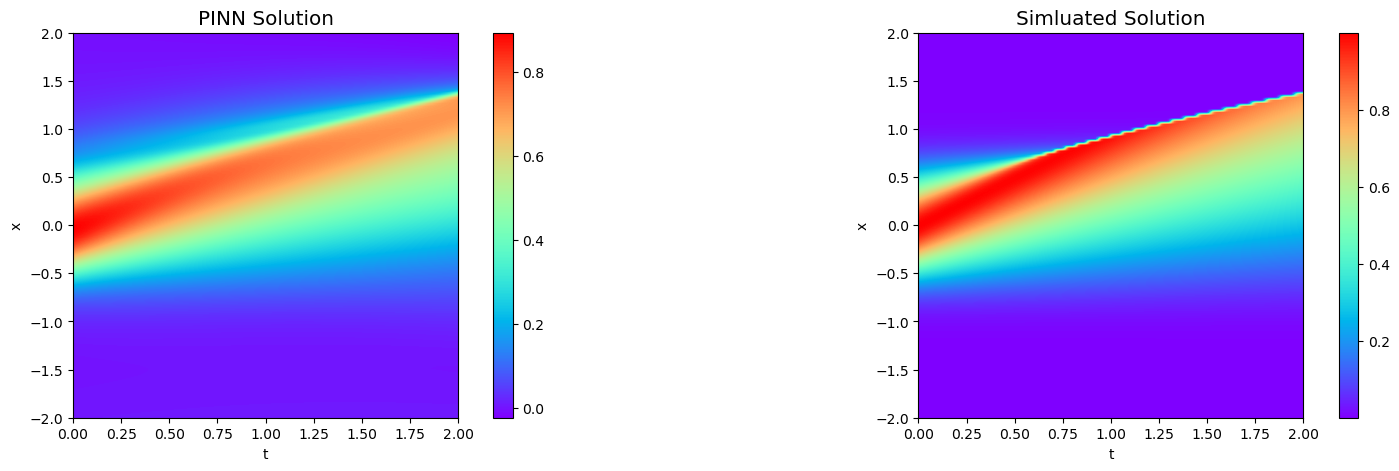

In [31]:
# plot best full-batch loss
hello = PINNs()
prediction = hello.apply(format_params_fn(papas[-1]), data_all)
u = prediction[:,0:1]

fig = plt.figure(figsize=(20, 5))
u_viz = (u.reshape(201, 129)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary 
ax1 = fig.add_subplot(1,2,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.5); 
plt.colorbar(mesh) 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN Solution', fontsize='x-large'); 

u_true = (label_all.reshape(201, 129)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary 
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.5); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated Solution', fontsize='x-large'); 

jnp.mean(jnp.square(label_all - u))

Write PINN prediction & ground truth to file

In [19]:
#np.save('nonlinear_sgd_minibatch_60s', (u_viz, u_true))